# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pylab
import pickle

import inflection

from sklearn.model_selection     import train_test_split
from sklearn.preprocessing       import OneHotEncoder, MinMaxScaler
from sklearn.linear_model        import LogisticRegression
from sklearn.ensemble            import RandomForestClassifier
from sklearn.metrics             import accuracy_score, classification_report
from sklearn.tree                import DecisionTreeClassifier
from sklearn.svm                 import SVC
from xgboost                     import XGBClassifier
from imblearn.over_sampling      import SMOTE

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## 0.1 Help Functions

In [2]:
#tamanho dos gráficos
def tamanho( x, y ):
    pylab.rcParams['figure.figsize'] = (x, y)

## 0.2 Loading Datasets

In [3]:
df_estacao = pd.read_csv('Estacao.csv', sep=',')
df_estacao.head()

,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.0
1,2020-09-01,01:00:00,0.0
2,2020-09-01,02:00:00,0.0
3,2020-09-01,03:00:00,0.0
4,2020-09-01,04:00:00,0.0


In [4]:
df_sensor = pd.read_csv('Sensor.csv', sep=',')
df_sensor.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01T01:00:00Z,39.0,31.366,9419,0,44923,31
3,2020-10-01T02:00:00Z,39.0,31.322,9419,0,44825,31
4,2020-10-01T03:00:00Z,38.0,31.240,9416,0,44728,31


# 1.0 DATA DESCRIPTION

## 1.1 Rename Columns

In [5]:
df_estacao.rename(columns={'Hora (Brasília)': 'hora'}, inplace=True)

In [6]:
df_sensor.rename(columns={'Datetime – utc': 'DataHora'}, inplace=True)

## 1.2 Merge dos Datasets

In [7]:
# Junção de hora e data no formato UTC do dataset Estação

df_estacao['data'] = pd.to_datetime(df_estacao['data'])
df_estacao['hora'] = pd.to_datetime(df_estacao['hora'], format='%H:%M:%S').dt.time

df_estacao['DataHora'] = df_estacao['data'].dt.strftime('%Y-%m-%d') + 'T' + df_estacao['hora'].astype(str) + 'Z'

df_estacao

,data,hora,chuva,DataHora
0,2020-09-01,00:00:00,0.0,2020-09-01T00:00:00Z
1,2020-09-01,01:00:00,0.0,2020-09-01T01:00:00Z
2,2020-09-01,02:00:00,0.0,2020-09-01T02:00:00Z
3,2020-09-01,03:00:00,0.0,2020-09-01T03:00:00Z
4,2020-09-01,04:00:00,0.0,2020-09-01T04:00:00Z
...,...,...,...,...
2251,2020-12-03,19:00:00,0.0,2020-12-03T19:00:00Z
2252,2020-12-03,20:00:00,0.0,2020-12-03T20:00:00Z
2253,2020-12-03,21:00:00,0.0,2020-12-03T21:00:00Z
2254,2020-12-03,22:00:00,0.0,2020-12-03T22:00:00Z


In [8]:
df = pd.merge(df_estacao, df_sensor, on='DataHora', how='right')
df

,data,hora,chuva,DataHora,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30,23:00:00,0.0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01,00:00:00,0.0,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01,01:00:00,0.0,2020-10-01T01:00:00Z,39.0,31.366,9419,0,44923,31
3,2020-10-01,02:00:00,0.0,2020-10-01T02:00:00Z,39.0,31.322,9419,0,44825,31
4,2020-10-01,03:00:00,0.0,2020-10-01T03:00:00Z,38.0,31.240,9416,0,44728,31
...,...,...,...,...,...,...,...,...,...,...
1706,NaT,NaN,NaN,2020-12-11T09:00:00Z,82.0,19.480,9422,3,20669,17
1707,NaT,NaN,NaN,2020-12-11T10:00:00Z,69.0,24.000,9429,3,20606,19
1708,NaT,NaN,NaN,2020-12-11T11:00:00Z,63.0,25.440,9436,3,20529,25
1709,NaT,NaN,NaN,2020-12-11T12:00:00Z,60.0,27.160,9439,3,20442,28


## 1.3 Treatment Date and Time

In [9]:
df['DataHora'] = pd.to_datetime(df['DataHora'])

In [10]:
df['data'] = df['DataHora'].dt.date

In [11]:
df['hora'] = df['DataHora'].dt.time

In [12]:
df['data'] = pd.to_datetime(df['data'])

## 1.4 Data Types

In [13]:
df.dtypes

data                        datetime64[ns]
hora                                object
chuva                              float64
DataHora               datetime64[ns, UTC]
air_humidity_100                   float64
air_temperature_100                float64
atm_pressure_main                    int64
num_of_resets                        int64
piezo_charge                         int64
piezo_temperature                    int64
dtype: object

## 1.5 Data Dimension

In [14]:
print( 'Numero de linhas: {}'.format( df.shape[0] ) )
print( 'Number de colunas: {}'.format( df.shape[1] ) )

Numero de linhas: 1711
Number de colunas: 10


## 1.6 Check NA

In [15]:
df.isna().sum()

data                     0
hora                     0
chuva                  183
DataHora                 0
air_humidity_100         6
air_temperature_100      6
atm_pressure_main        0
num_of_resets            0
piezo_charge             0
piezo_temperature        0
dtype: int64

## 1.7 Fillout NA

In [16]:
air_humidity_100 = df['air_humidity_100'].mean()
air_temperature_100 = df['air_temperature_100'].mean()
chuva = df['chuva'].mean()

In [17]:
df.update(df['air_humidity_100'].fillna(air_humidity_100))
df.update(df['air_temperature_100'].fillna(air_temperature_100))
df.update(df['chuva'].fillna(chuva))

## 1.8 Feature Engineering

In [18]:
# year
df['year'] = df['data'].dt.year

# month
df['month'] = df['data'].dt.month

# day
df['day'] = df['data'].dt.day

# week of year
df['week_of_year'] = df['data'].dt.weekofyear

## 1.9 Descriptive Statistics

In [19]:
num_attributes = df.select_dtypes(include = ['int64', 'float64'])

cat_attributes = df.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.9.1 Numerical Atributes

In [20]:
num_attributes.nunique()

chuva                    28
air_humidity_100         88
air_temperature_100     973
atm_pressure_main       143
num_of_resets             4
piezo_charge           1693
piezo_temperature        37
year                      1
month                     4
day                      31
week_of_year             11
dtype: int64

In [21]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,chuva,0.00,16.800,16.800,0.093194,0.00,0.782662,14.156959,240.756360
1,air_humidity_100,13.00,99.000,86.000,60.238710,61.00,22.054974,-0.156821,-1.122700
2,air_temperature_100,12.36,42.664,30.304,24.660940,23.06,6.161576,0.594174,-0.468222
3,atm_pressure_main,9350.00,9507.000,157.000,9432.838106,9433.00,26.370624,-0.218423,-0.038030
4,num_of_resets,0.00,3.000,3.000,1.646406,2.00,1.090063,-0.080707,-1.322082
5,piezo_charge,16950.00,65533.000,48583.000,42462.030392,41765.00,13034.427608,0.038807,-1.097561
6,piezo_temperature,11.00,47.000,36.000,24.910579,22.00,8.371674,0.634002,-0.784482
7,year,2020.00,2020.000,0.000,2020.000000,2020.00,0.000000,0.000000,0.000000
8,month,9.00,12.000,3.000,10.717124,11.00,0.707763,0.455510,-0.912401
9,day,1.00,31.000,30.000,14.287551,13.00,8.918441,0.239954,-1.198728


### 1.9.2. Categorical Atributes

In [22]:
cat_attributes.nunique()

hora          25
DataHora    1711
dtype: int64

In [23]:
df

,data,hora,chuva,DataHora,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,year,month,day,week_of_year
0,2020-09-30,23:00:00,0.000000,2020-09-30 23:00:00+00:00,38.00000,31.36600,9412,0,45123,30,2020,9,30,40
1,2020-10-01,00:00:00,0.000000,2020-10-01 00:00:00+00:00,60.23871,24.66094,9412,0,45025,31,2020,10,1,40
2,2020-10-01,01:00:00,0.000000,2020-10-01 01:00:00+00:00,39.00000,31.36600,9419,0,44923,31,2020,10,1,40
3,2020-10-01,02:00:00,0.000000,2020-10-01 02:00:00+00:00,39.00000,31.32200,9419,0,44825,31,2020,10,1,40
4,2020-10-01,03:00:00,0.000000,2020-10-01 03:00:00+00:00,38.00000,31.24000,9416,0,44728,31,2020,10,1,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,2020-12-11,09:00:00,0.093194,2020-12-11 09:00:00+00:00,82.00000,19.48000,9422,3,20669,17,2020,12,11,50
1707,2020-12-11,10:00:00,0.093194,2020-12-11 10:00:00+00:00,69.00000,24.00000,9429,3,20606,19,2020,12,11,50
1708,2020-12-11,11:00:00,0.093194,2020-12-11 11:00:00+00:00,63.00000,25.44000,9436,3,20529,25,2020,12,11,50
1709,2020-12-11,12:00:00,0.093194,2020-12-11 12:00:00+00:00,60.00000,27.16000,9439,3,20442,28,2020,12,11,50


# 3.0. FILTERING OF VARIABLES

## 3.1 Selecao das Colunas

In [24]:
df.drop(columns=['DataHora'], inplace=True)

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [25]:
df['rotulo'] = df['chuva'].map(lambda x: 0 if x == 0 else 1)

## 4.1 Análise Univariada

### 4.1.1 Variavel Resposta

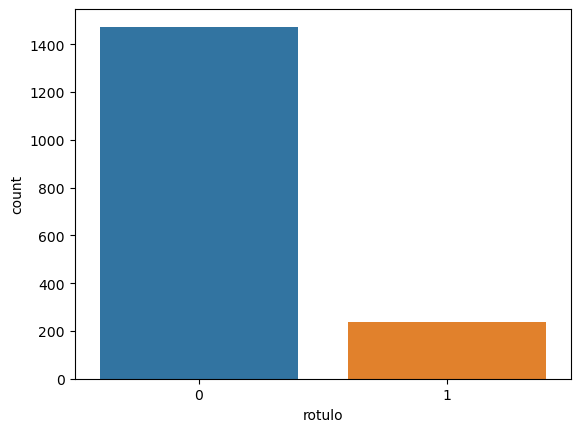

In [26]:
sns.countplot(df['rotulo']);

### 4.1.2. Variável Numérica

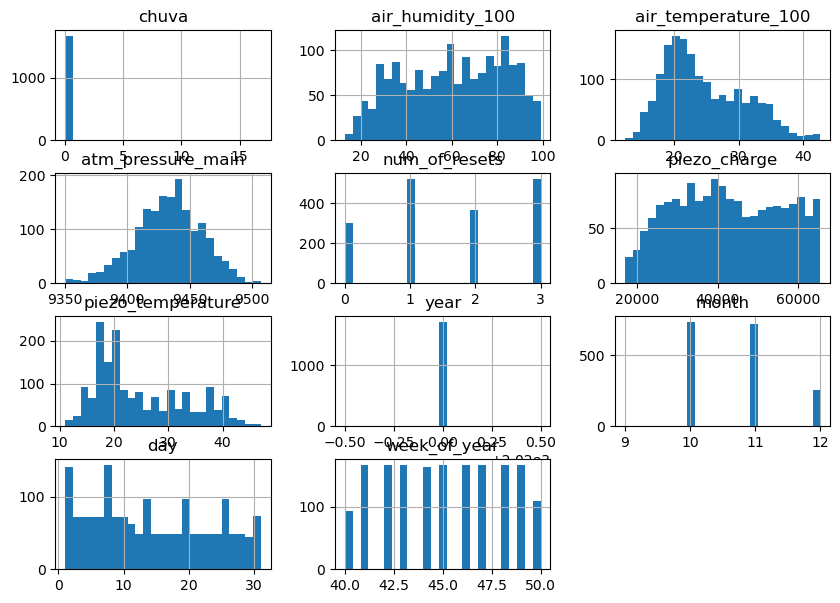

In [27]:
num_attributes.hist(bins=25, figsize=(10, 7));

## 4.2. Análise Bivariada

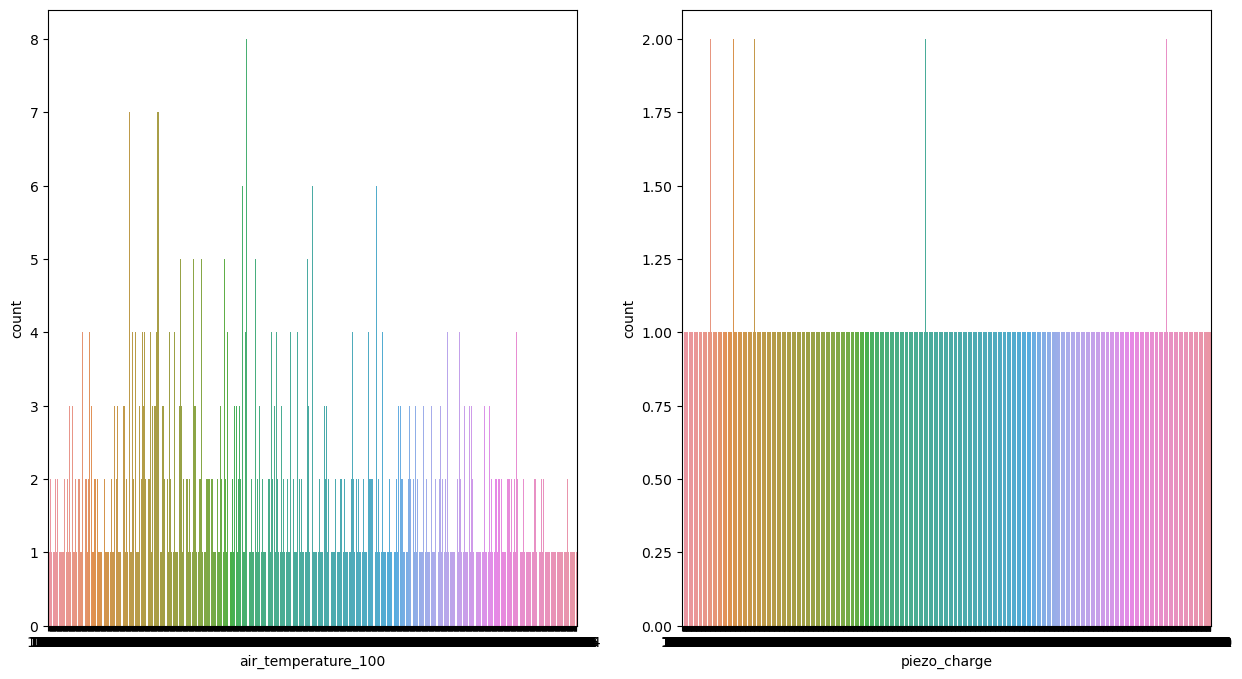

In [28]:
pylab.rcParams['figure.figsize'] = (15.0, 8.0)
plt.subplot(1, 2, 1)
sns.countplot(df['air_temperature_100']);

plt.subplot(1, 2, 2)
sns.countplot(df['piezo_charge']);

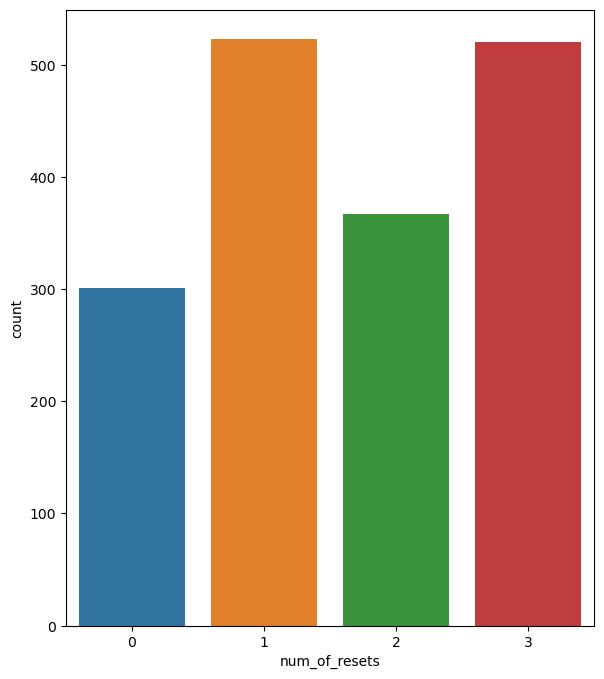

In [29]:
plt.subplot(1, 2, 2)
sns.countplot(df['num_of_resets']);

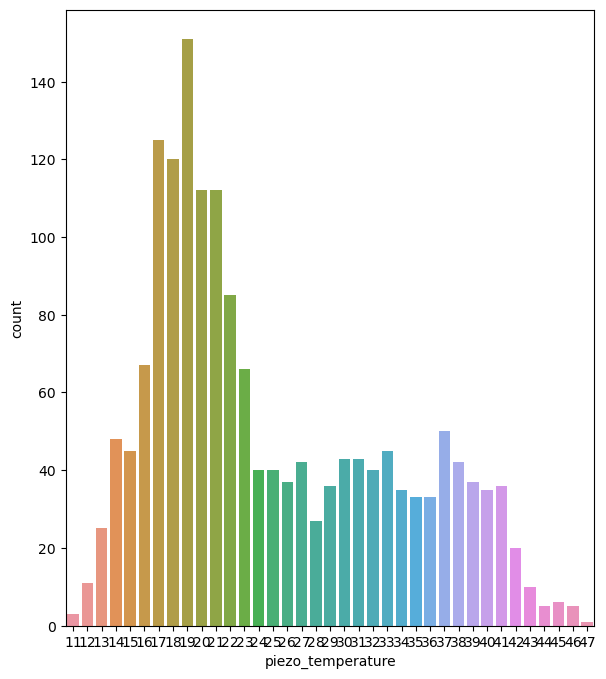

In [30]:
plt.subplot(1, 2, 2)
sns.countplot(df['piezo_temperature']);

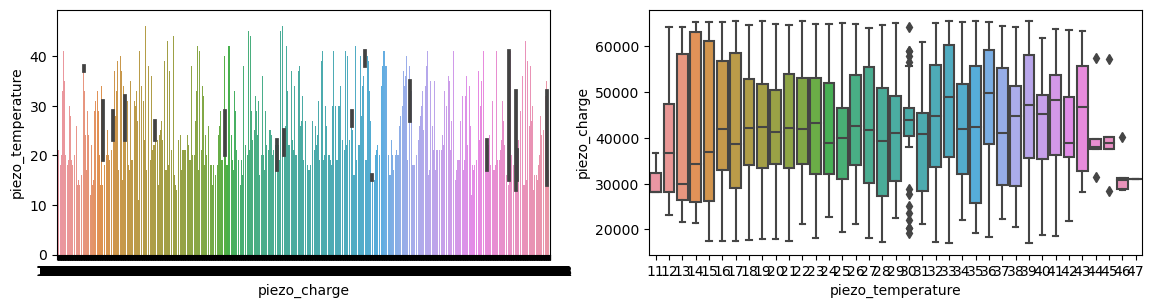

In [31]:
tamanho(14, 7)
plt.subplot(2, 2, 1)
sns.barplot(x='piezo_charge', y='piezo_temperature', data=df);

plt.subplot(2, 2, 2)
sns.boxplot(x='piezo_temperature', y='piezo_charge', data=df);

## 4.3 Análise Multivariada

### 4.3.1. Atributos Numéricos

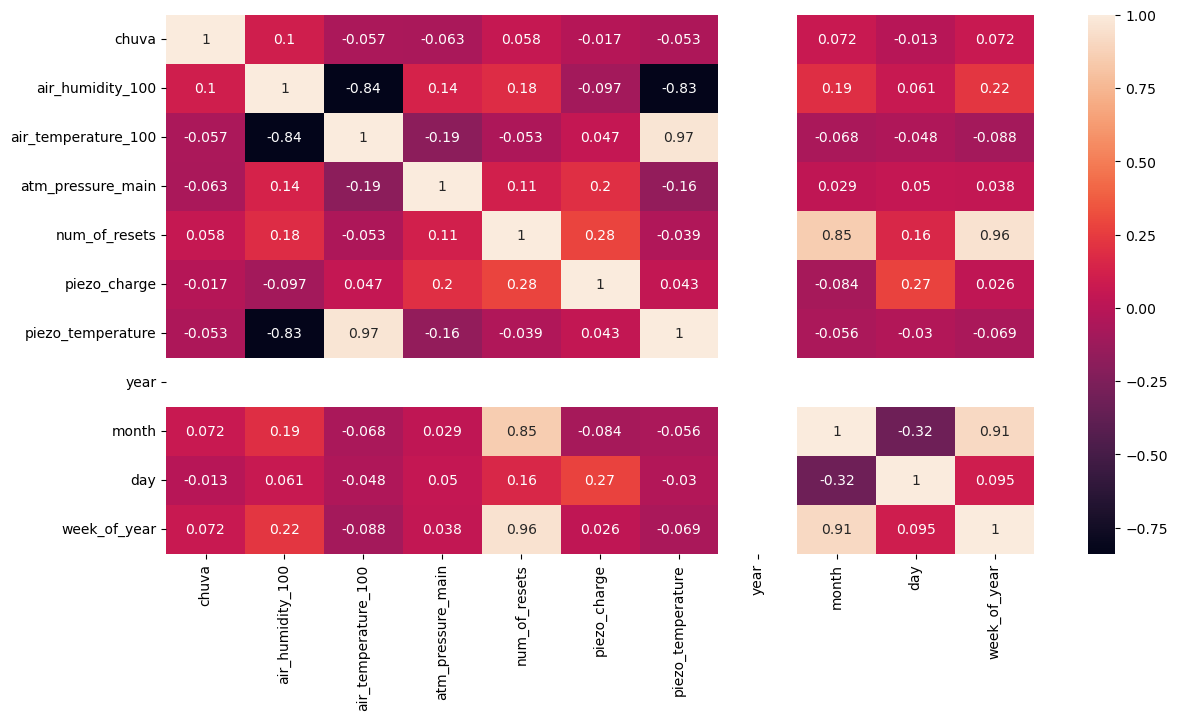

In [32]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot=True );

# 5.0 DATA PREPARATION

## 5.1. Encoding

In [33]:
X_cat = cat_attributes[['hora']]

onn = OneHotEncoder()

X_cat = onn.fit_transform(X_cat).toarray()

X_cat = pd.DataFrame(X_cat)

X_numerical = num_attributes[['air_humidity_100', 'air_temperature_100', 'air_temperature_100', 'atm_pressure_main',
                              'num_of_resets', 'piezo_charge', 'piezo_temperature', 'year', 'month', 'week_of_year', 'day']]

df1 = pd.concat([X_numerical, X_cat], axis=1)

df_all = pd.concat([df1, df['rotulo']], axis=1)

## 5.2. Balanceamento da variável resposta

In [34]:
x = df_all.iloc[:,0:36]
y = df_all.iloc[:, -1]

smote = SMOTE()

x, y = smote.fit_resample(x,y)

## 5.3 Rescaling

In [35]:
mms = MinMaxScaler()

x = mms.fit_transform(x)

# 6.0 MODELO DE MACHINE LEARNING

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

## 6.1. Random Forest

In [37]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [38]:
y_pred = random_forest.predict(X_test)
accuracy_score(y_test, y_pred)*100

97.85067873303167

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       437
           1       0.99      0.97      0.98       447

    accuracy                           0.98       884
   macro avg       0.98      0.98      0.98       884
weighted avg       0.98      0.98      0.98       884



## 6.2. Regressão Logística

In [40]:
regr_logist = LogisticRegression()
regr_logist.fit(X_train, y_train)

LogisticRegression()

In [41]:
y_pred = regr_logist.predict(X_test)
accuracy_score(y_test, y_pred)*100

89.47963800904978

In [42]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.90      0.89       437
           1       0.90      0.89      0.90       447

    accuracy                           0.89       884
   macro avg       0.89      0.89      0.89       884
weighted avg       0.89      0.89      0.89       884



## 6.3. Decision Tree

In [43]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
y_pred = decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)*100

96.49321266968326

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       437
           1       0.95      0.99      0.97       447

    accuracy                           0.96       884
   macro avg       0.97      0.96      0.96       884
weighted avg       0.97      0.96      0.96       884



## 6.4. SVM

In [46]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [47]:
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)*100

92.87330316742081

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       437
           1       0.94      0.92      0.93       447

    accuracy                           0.93       884
   macro avg       0.93      0.93      0.93       884
weighted avg       0.93      0.93      0.93       884



## 6.5. XGBoost

In [49]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [50]:
y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)*100

98.30316742081448

In [51]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       437
           1       0.99      0.98      0.98       447

    accuracy                           0.98       884
   macro avg       0.98      0.98      0.98       884
weighted avg       0.98      0.98      0.98       884



# 7.0 SALVANDO O CLASSIFICADOR

In [52]:
with open('variaveismodelo.pkl', 'wb') as f:
    pickle.dump([smote, onn, mms, random_forest, regr_logist, decision_tree, svm, xgb], f)